# Momentum Channel Breakout Strategy

The **momentum breakout strategy** is a trading approach designed to capture strong directional moves in an asset’s price. It is based on the principle that **once prices break through important levels of support or resistance with momentum, they are likely to continue in that direction** for some time.
#### Core Idea
Markets often trade within ranges (sideways price action), but when buying or selling pressure becomes strong enough, prices can "break out" of these ranges. A breakout signals a shift in supply and demand dynamics and often marks the beginning of a new trend.

This research:
   - Uses recent highs/lows to define breakout points.
   - Go **long** when price breaks above a resistance level with momentum.  
   - Go **short** when price breaks below a support level with momentum.
#### Why It Works
- Breakouts often occur when large institutional traders enter the market, creating sustained trends.  
- Momentum ensures that the move is not just random noise but supported by strong market participation.  
- The strategy aims to **ride the wave of volatility** and profit from rapid price expansions.  

**In summary:** A momentum breakout strategy attempts to systematically exploit periods when the market breaks away from equilibrium, betting that strong moves will continue long enough to generate consistent profits.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional
import statsmodels.api as sm
from time import time

## Data Loading and Preparation

We first load price data OHLCV and clean it.

In [2]:
df = pd.read_pickle('../data/binance_1D_crypto_data.pkl')
df = df[df['open_time'].dt.date != df['open_time'].dt.date.max()]
df = df.drop_duplicates(keep='first')
df.head()

,open_time,open,high,low,close,volume,symbol
0,2024-06-17,0.09500000,0.29500000,0.09500000,0.21300000,1558854668.40000000,ZKUSDT
1,2024-06-18,0.21300000,0.23200000,0.18600000,0.22020000,1189119720.30000000,ZKUSDT
2,2024-06-19,0.22020000,0.24000000,0.21260000,0.22420000,727374424.10000000,ZKUSDT
3,2024-06-20,0.22420000,0.22420000,0.19100000,0.19830000,493478200.90000000,ZKUSDT
4,2024-06-21,0.19830000,0.20360000,0.17600000,0.18220000,382766488.90000000,ZKUSDT


High, Low, Close Prices are used to detect a breakout, volume is also used to confirm a trend. All assets/columns that have more than 10% null values are removed

In [3]:
def pivot_reindexed_data(df, value):
    new_df = df.pivot(values = value, columns = 'symbol', index = 'open_time')
    new_df = pd.DataFrame(new_df).astype(float)
    new_df = new_df.reindex(pd.date_range(new_df.index[0],new_df.index[-1],freq='1d'))
    return new_df

px_close = pivot_reindexed_data(df,'close').loc[:'2025-08']
# Omitting tickers with less than 90% of non null values.
px_close = px_close.loc[:,(px_close.notna().sum()/(px_close.shape[0]))>= 0.9]

px_high = pivot_reindexed_data(df,'high')[px_close.columns].loc[:'2025-08']
px_low = pivot_reindexed_data(df,'low')[px_close.columns].loc[:'2025-08']
vols = pivot_reindexed_data(df,'volume')[px_close.columns].loc[:'2025-08']


# Define date ranges
insample_start = pd.Timestamp("2021-06-01")
insample_end = pd.Timestamp("2023-12-31")

outsample_start = pd.Timestamp("2024-01-01")

px_close_train = px_close.loc[:insample_end]
px_high_train = px_high.loc[:insample_end]
px_low_train = px_low.loc[:insample_end]
vols_train = vols.loc[:insample_end]

In [4]:
px_close.tail()

symbol,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,TUSDUSDT,TWTUSDT,UNIUSDT,USDCUSDT,VETUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2025-08-27,0.2496,320.63,0.8509,0.2475,6.59,4.491,24.42,2.304,550.2,855.18,...,0.3451,0.9977,0.7581,9.854,0.9998,0.02487,0.3790,2.9688,0.7872,42.27
2025-08-28,0.2538,317.56,0.8576,0.2528,6.87,4.782,24.93,2.397,557.9,873.47,...,0.3451,0.9974,0.7541,10.018,0.9999,0.02561,0.3822,2.9665,0.7842,42.47
2025-08-29,0.2444,319.20,0.8266,0.2365,6.38,4.483,23.55,2.251,530.7,862.30,...,0.3385,0.9971,0.7352,9.633,0.9999,0.02425,0.3614,2.8195,0.7335,40.21
2025-08-30,0.2469,319.39,0.8224,0.2337,6.43,4.505,23.78,2.292,552.8,862.00,...,0.3390,0.9967,0.7383,9.726,0.9998,0.02471,0.3600,2.8181,0.7369,40.05
2025-08-31,0.2421,315.69,0.8113,0.2316,6.35,4.467,23.40,2.522,544.2,857.65,...,0.3410,0.9966,0.7368,9.619,0.9999,0.02414,0.3528,2.7757,0.7199,40.43


In [5]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    return drawdown

In [6]:
def duration(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    if isinstance(returns, pd.DataFrame):
        ddd = pd.DataFrame(index = returns.index, columns = returns.columns)
        for col in returns.columns:
            ddd[col] = duration[col].groupby((duration[col] != duration[col].shift()).cumsum()).cumsum()
    else:
        ddd = duration.groupby((duration != duration.shift()).cumsum()).cumsum()
    return ddd

In [7]:
def calculate_metrics(returns, benchmark:Optional = False):
    """
    Compute total return, annualized return/vol, Sharpe, max drawdown, win rate.
    """
    
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    max_duration = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()

    cum_ret = cumulative.iloc[-1] - 1
    ann_vol = returns.std() * np.sqrt(365)
    ann_ret = returns.mean() * 365
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = drawdown.min()

    # consider only non-zero returns as individual trades
    trade_rets = returns[returns != 0]
    win_rate   = (trade_rets > 0).sum() / len(trade_rets)
    
    
    metrics = pd.Series({
        "Cumulative Return": f"{(cum_ret * 100):.2f}%",
        "Annualized Return": f"{(ann_ret * 100):.2f}%",
        "Annualized Volatility": f"{(ann_vol * 100):.2f}%",
        "Sharpe Ratio": sharpe,
        "Max Drawdown": f"{(max_dd * 100):.2f}%",
        "Max Drawdown Duration": f"{(max_duration):.2f} days",
        "Win Rate": f"{(win_rate * 100):.2f}%"
    })
    
    if benchmark:
        bench_rets = px_close['BTCUSDT'].ffill().pct_change().loc[returns.index]
        X = sm.add_constant(bench_rets)
        y = returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta  = model.params['BTCUSDT']
        active_rets = returns - beta * bench_rets
        IR = active_rets.mean() / active_rets.std() * np.sqrt(365)
    
        metrics["Info Ratio"] = IR
    else: metrics["Info Ratio"] = 'N/A'

    return metrics

In [8]:
def backtest_with_costs(prices, port, tcost_bps = 20):
    ret = prices.ffill().pct_change()
    gross_ret = (port.shift() * ret).sum(axis=1)

    # Turnover
    turnover = (port.fillna(0) - port.shift().fillna(0)).abs().sum(axis=1)

    # Cost in return units
    cost = turnover * (tcost_bps * 1e-4)
    net_ret = gross_ret - cost

    return net_ret, gross_ret, turnover

In [9]:
def channel_bounds(high, low, le_lookback, se_lookback):
    """
    Highest high / lowest low over last 'lookback' bars, inclusive.
    """
    higher = high.rolling(le_lookback, min_periods=le_lookback).max()
    lower = low.rolling(se_lookback, min_periods=se_lookback).min()
    return higher, lower

In [10]:
def volume_filter_mask(volm, lookback, pctile):
    """
    True where today's volume > rolling quantile (time-series) over the last 'lookback' days.
    Uses yesterday's threshold to avoid lookahead.
    """
    q = volm.rolling(lookback, min_periods=lookback).quantile(pctile)
    return volm > q.shift(1)

In [11]:
def breakout_entries(high, low, close, le_lookback, se_lookback,
                     volm: Optional = None, vol_lb: Optional = None, vol_pct: Optional = None):
    """
    Long entry when close[t] > higher[t-1]
    Short entry when close[t] < lower[t-1]
    Optional: apply a volume filter.
    """
    higher_L, lower_S = channel_bounds(high, low, le_lookback, se_lookback)
    
    long_entry = close > higher_L.shift(1) 
    short_entry = close < lower_S.shift(1)

    if volm is not None and vol_lb and vol_pct is not None:
        vol_ok = volume_filter_mask(volm, lookback=vol_lb, pctile=vol_pct)
        long_entry  = long_entry & vol_ok
        short_entry = short_entry & vol_ok

    return long_entry.fillna(False), short_entry.fillna(False)

In [12]:
def exit_masks_channel_separate(high, low, close, exit_long_lookback, exit_short_lookback):
    """
    Long exit: close < lower(EL)[t-1]
    Short exit: close > upper(ES)[t-1]
    """
    higher_EL, lower_ES = channel_bounds(high, low, exit_short_lookback, exit_long_lookback)
    long_exit  = close < lower_ES.shift(1) 
    short_exit = close > higher_EL.shift(1) 
    
    return long_exit.fillna(False), short_exit.fillna(False)

In [13]:
def _age_matrix_from_positions(pos_df):
    """
    Compute per-asset holding age in bars for nonzero positions.
    Age resets to 1 on the bar a position is opened or flips side.
    """
    ages = []
    for c in pos_df.columns:
        x = pos_df[c].to_numpy()
        a = np.zeros_like(x, dtype=int)
        last = 0
        run = 0
        for i, v in enumerate(x):
            if v == 0:
                run = 0
            else:
                if v != last:
                    run = 1
                else:
                    run += 1
            a[i] = run
            last = v
        ages.append(pd.Series(a, index=pos_df.index, name=c))
    return pd.concat(ages, axis=1)

## Trading Strategy: Channel Breakout

This strategy constructs **long and short positions** based on price breakouts using **highest-high / lowest-low channels**, optional **volume filters**, and **holding period limits**.

---
#### 1. Channel Boundaries

Compute rolling channel bounds:

$$
\text{Higher}_t = \max(\text{high}_{t - le\_lookback + 1 : t})
$$  
$$
\text{Lower}_t = \min(\text{low}_{t - se\_lookback + 1 : t})
$$

Used for entries and exits. Where $le\_lookback$ = long entry lookback and $se\_lookback$ = short entry lookback.

---
#### 2. Entry Signals

Long / short entries occur on breakout outside the previous period's channel:

$$
\text{Long Entry}_t = \mathbf{1}_{\{ \text{close}_t > \text{Higher}_{t-1} \}}
$$  
$$
\text{Short Entry}_t = \mathbf{1}_{\{ \text{close}_t < \text{Lower}_{t-1} \}}
$$

Optional **volume filter**: only take trades when  

$$
\text{volume}_t > Q_{\text{lookback}}(\text{volume}, \text{pctile})
$$

---
#### 3. Exit Rules

**Price-based exits**: exit when price returns inside the opposite channel:

$$
\text{Long Exit}_t = \mathbf{1}_{\{ \text{close}_t < \text{Lower Exit}_{t-1} \}}
$$  
$$
\text{Short Exit}_t = \mathbf{1}_{\{ \text{close}_t > \text{Higher Exit}_{t-1} \}}
$$

**Time-based exit**: exit after maximum holding period \(M\):

$$
\text{Position}_t = 0 \quad \text{if age} > M
$$

---

#### 4. Position Construction

At each time step \(t\):  

1. Previous positions are carried forward :
   $$
   \text{Position}_t = \text{Position}_{t-1}
   $$  
   
2. New entries are applied depending on signal:  
   $$
   \text{Position}_t[\text{Long Entry}_t] = 1, \quad
   \text{Position}_t[\text{Short Entry}_t] = -1
   $$  
   
3. Exits are applied (price and time-based).

In [14]:
def build_positions(high, low, close, le_lookback, se_lookback, exit_params: Dict,
                        volm: Optional = None, vol_lb: Optional = None, vol_pct: Optional = None):
    """
    Builds positions using the channel and holding period exit logic.
    exit_params are:
      - 'M': int, max holding period (time-based exit)
      - 'exit_llb': int, long exit lookback
      - 'exit_slb': int, short exit lookback
    """
    nrows, ncols = close.shape
    pos = np.zeros((nrows, ncols), dtype=np.int8)

    # Entries
    long_entry, short_entry = breakout_entries(
        high, low, close, le_lookback, se_lookback,
        volm=volm, vol_lb=vol_lb, vol_pct=vol_pct)

    # Price-based exits (channel)
    el = int(exit_params.get("exit_llb", le_lookback))
    es = int(exit_params.get("exit_slb", se_lookback))
    long_exit_mask, short_exit_mask = exit_masks_channel_separate(high, low, close, el, es)

    # Event loop
    for t in range(1, nrows):
        pos[t] = pos[t-1]
        
        le = long_entry.iloc[t].to_numpy()
        se = short_entry.iloc[t].to_numpy()
        
        pos[t, le] = 1
        pos[t, se] = -1

        # Apply price-based exits (channel)
        long_exit_now  = long_exit_mask.iloc[t].to_numpy()
        short_exit_now = short_exit_mask.iloc[t].to_numpy()
        pos[t, (pos[t] > 0) & long_exit_now]  = 0
        pos[t, (pos[t] < 0) & short_exit_now] = 0

    pos_df = pd.DataFrame(pos, index=close.index, columns=close.columns)

    # Time-based exit
    M = int(exit_params.get("M", 0))
    if M > 0:
        age_df = _age_matrix_from_positions(pos_df)
        pos_df = pos_df.mask((age_df > M) & (pos_df != 0), 0)

    return pos_df

### Portfolio Construction from Positions
After generating the raw positions, we construct the **final tradable portfolio** by **risk-scaling, smoothing, and normalizing** the positions.
#### 1. Risk-Scaling by Volatility
Positions are scaled by recent asset volatility:
$$
\text{pos}_t^i \leftarrow \text{pos}_t^i \times \sqrt{\sigma_t^i}
$$
where:
$$
\sigma_t^i = \text{StdDev}(\text{ret}^i_{t-29:t})
$$

- Computes a **30-period rolling standard deviation** for each asset \(i\).  
- Higher-volatility assets are scaled down to reduce risk contribution.

---
#### 2. Smoothing Positions
To reduce sharp changes in exposure, positions are smoothed using an **Exponential Weighted Moving Average (EWMA)**:

$$
\text{pos}_t^i \leftarrow \text{EWMA}(\text{pos}_t^i, \alpha)
$$
- $(\alpha = 1/3$) controls responsiveness to new signals.  
- Ensures smoother transitions and lower turnover.

---
#### 3. Normalization for Fully Invested Portfolio
Finally, positions are normalized to ensure total exposure sums to 1:
$$
w_t^i = \frac{\text{pos}_t^i}{\sum_j |\text{pos}_t^j|}
$$
Creates a **fully-invested portfolio** ($(\sum_i |w_t^i| = 1$)).  

---
The resulting portfolio `port` is now ready for **backtesting or live implementation**.

In [15]:
def backtest_breakout(high, low, close, le_lookback, se_lookback, exit_params, start_date):
    """
    Run a single strategy and return summary metrics.
    """

    ret = close.ffill().pct_change()
    
    pos = build_positions(high = high, low = low, close = close, 
                           le_lookback = le_lookback, se_lookback = se_lookback,
                           exit_params =exit_params,
                           volm=vols, vol_lb=50, vol_pct=0.68
                            )
    pos = pos * np.sqrt(ret.rolling(35, min_periods = 1).std())

    port = pos.divide(pos.abs().sum(1), 0).loc[start_date:]
    
    prices = close.loc[start_date:] 
    net_ret, gross_ret , turnover = backtest_with_costs(prices, port)
    
    metrics = calculate_metrics(net_ret, benchmark = True)

    return {
        "Entry_Long":        int(le_lookback),
        "Entry_Short":       int(se_lookback),
        "ExitParam":         list(exit_params.values()),
        "Annualized Return": metrics['Annualized Return'],  
        "Annualized Vol":    metrics['Annualized Volatility'],
        "Sharpe":            metrics['Sharpe Ratio'],
        "Info Ratio":        metrics['Info Ratio'],
        "Max Drawdown":      metrics['Max Drawdown'],
        "Max DDD (days)":    metrics['Max Drawdown Duration'], 
        "Win Rate":          metrics['Win Rate'],
        "Avg Turnover":      float(turnover.mean()),
    }

In [16]:
def run_grid_new(high, low, close, le_lookback, se_lookback, exits, start_date):
    """
    Run grid over entry lookbacks and exits.
      le_lookback: e.g., [20, 30, 50, 100]
    """
    rows = []
    for N in le_lookback:
        for M in se_lookback:
            for params in exits:
                res = backtest_breakout(high=high, low=low, close=close,
                                        le_lookback=N, se_lookback=M, exit_params=params,
                                        start_date = start_date)
                rows.append(res)

    out = pd.DataFrame(rows)
    out = out.sort_values(["Sharpe", "Annualized Return"], ascending=False).reset_index(drop=True)
    return out

In [17]:
le_lookback = [x for x in range(26,50,4)]
se_lookback = [x for x in range(35,50,2)]

exits = [
    {"M": 31, "exit_llb": 2, "exit_slb": 40},
    {"M": 33, "exit_llb": 2, "exit_slb": 40},
    {"M": 37, "exit_llb": 2, "exit_slb": 40}]

# RUN GRID
output = run_grid_new(px_high_train, px_low_train, px_close_train,
                  le_lookback = le_lookback, se_lookback = se_lookback, 
                  exits = exits,
                  start_date = insample_start)
output[:10]

,Entry_Long,Entry_Short,ExitParam,Annualized Return,Annualized Vol,Sharpe,Info Ratio,Max Drawdown,Max DDD (days),Win Rate,Avg Turnover
0,46,45,"[33, 2, 40]",128.32%,85.67%,1.497900,1.637816,-54.92%,358.00 days,51.29%,0.261150
1,46,43,"[33, 2, 40]",126.94%,85.89%,1.477915,1.619363,-55.19%,361.00 days,51.40%,0.260697
2,46,41,"[33, 2, 40]",125.04%,84.81%,1.474409,1.618367,-55.19%,361.00 days,51.51%,0.260596
3,46,35,"[33, 2, 40]",123.69%,84.08%,1.471207,1.620654,-53.59%,251.00 days,50.65%,0.255978
4,46,37,"[33, 2, 40]",124.21%,84.66%,1.467166,1.610375,-55.68%,361.00 days,51.08%,0.257778
5,46,39,"[33, 2, 40]",124.24%,84.77%,1.465628,1.609445,-55.68%,361.00 days,51.18%,0.260126
6,46,47,"[33, 2, 40]",125.47%,85.78%,1.462589,1.597424,-57.97%,361.00 days,51.24%,0.262614
7,46,49,"[33, 2, 40]",124.83%,85.37%,1.462246,1.599219,-58.34%,361.00 days,51.35%,0.258975
8,46,45,"[37, 2, 40]",121.73%,84.54%,1.439968,1.591398,-54.90%,251.00 days,51.13%,0.250491
9,46,43,"[37, 2, 40]",121.72%,84.77%,1.435944,1.588563,-55.13%,361.00 days,51.13%,0.250200


## Walk Forward Validation

In [18]:
# WALK FORWARD VALIDATION SPLITS
splits = [
    ("2021-01", "2021-06", "2021-07", "2021-12"),
    ("2021-01", "2021-12", "2022-01", "2022-06"),
    ("2021-01", "2022-06", "2022-07", "2022-12"),
    ("2021-01", "2022-12", "2023-01", "2023-06"),
    ("2021-01", "2023-06", "2023-07", "2023-12"),
    ]

In [19]:
results = []
for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for N in le_lookback:
        for M in se_lookback:
            for params in exits:
                sharpe_val = backtest_breakout(px_high_train.loc[:val_end], px_low_train.loc[:val_end], 
                                        px_close_train.loc[:val_end],
                                        le_lookback = N, 
                                        se_lookback = M, 
                                        exit_params = params,
                                        start_date = val_start)['Sharpe']
                results.append({
                    "split": split_id,
                    "le_lookback": N,
                    "se_lookback": M,
                    "exits": str(list(params.values())),
                    "val_sharpe": sharpe_val
                })
    end = time()
    print(split_id," ",end-begin, " seconds")

cv_results = pd.DataFrame(results)

# Average validation performance
avg_scores = cv_results.groupby(["le_lookback", "se_lookback", "exits"])["val_sharpe"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["val_sharpe"].idxmax()]

print("\nAverage validation scores (top 5):")
print(avg_scores.sort_values("val_sharpe", ascending=False).head())

1   22.112746000289917  seconds
2   23.704763889312744  seconds
3   25.6865017414093  seconds
4   27.356271028518677  seconds
5   29.262820720672607  seconds

Average validation scores (top 5):
     le_lookback  se_lookback        exits  val_sharpe
136           46           45  [33, 2, 40]    1.467231
121           46           35  [33, 2, 40]    1.458345
133           46           43  [33, 2, 40]    1.453630
130           46           41  [33, 2, 40]    1.450719
124           46           37  [33, 2, 40]    1.448570


In [20]:
print("Parameters with non negative scores across all validation sets: ")
a_filter =(cv_results.groupby(["le_lookback", "se_lookback", "exits"])["val_sharpe"].min() > 0).reset_index()
print(avg_scores[a_filter.val_sharpe].sort_values("val_sharpe", ascending=False))
print("*** All parameter sets have atleast on negative sharpe in the validation sets", "\n")

print(cv_results[(cv_results.le_lookback == 46) & (cv_results.se_lookback == 45) & 
                 (cv_results.exits == '[33, 2, 40]')].set_index('split'), "\n")

print(cv_results[(cv_results.le_lookback == 46) & (cv_results.se_lookback == 35) & 
                 (cv_results.exits == '[33, 2, 40]')].set_index('split'))

print(cv_results[(cv_results.le_lookback == 46) & (cv_results.se_lookback == 43) & 
                 (cv_results.exits == '[33, 2, 40]')].set_index('split'))

Parameters with non negative scores across all validation sets: 
Empty DataFrame
Columns: [le_lookback, se_lookback, exits, val_sharpe]
Index: []
*** All parameter sets have atleast on negative sharpe in the validation sets 

       le_lookback  se_lookback        exits  val_sharpe
split                                                   
1               46           45  [33, 2, 40]    1.822185
2               46           45  [33, 2, 40]    2.266280
3               46           45  [33, 2, 40]   -1.003735
4               46           45  [33, 2, 40]    2.383779
5               46           45  [33, 2, 40]    1.867646 

       le_lookback  se_lookback        exits  val_sharpe
split                                                   
1               46           35  [33, 2, 40]    1.781304
2               46           35  [33, 2, 40]    2.203665
3               46           35  [33, 2, 40]   -0.832246
4               46           35  [33, 2, 40]    2.221055
5               46           35

All parameters sets have atleast one validation window with a negative sharpe.

In [21]:
agg = cv_results.groupby(["le_lookback", "se_lookback", "exits"])["val_sharpe"].agg(["mean","std"]).reset_index()

# penalize volatility
agg["robust_score"] = (agg["mean"] - agg["mean"].mean())/agg["mean"].std() \
                    - (agg["std"] - agg["std"].mean())/agg["std"].std()

agg = agg.set_index(['le_lookback','se_lookback','exits'])

best_5 = avg_scores.sort_values("val_sharpe", ascending=False)[:5]\
            .set_index(['le_lookback','se_lookback','exits'])

top5_score = agg.join(best_5, how = 'right').reset_index()
top5_score.sort_values(by = 'robust_score', ascending = False)

,le_lookback,se_lookback,exits,mean,std,robust_score,val_sharpe
1,46,35,"[33, 2, 40]",1.458345,1.294177,2.067876,1.458345
4,46,37,"[33, 2, 40]",1.448570,1.353576,1.275440,1.448570
0,46,45,"[33, 2, 40]",1.467231,1.402724,1.095522,1.467231
2,46,43,"[33, 2, 40]",1.453630,1.391788,0.967510,1.453630
3,46,41,"[33, 2, 40]",1.450719,1.391908,0.914492,1.450719


In [22]:
# Checking Information Ratio within top 5 parameter sets
results = []
for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for N in [46]:
        for M in [35, 37, 41, 43, 45]:
            for params in [{"M": 33, "exit_llb": 2, "exit_slb": 40}]:
                sharpe_val = backtest_breakout(px_high_train.loc[:val_end], px_low_train.loc[:val_end], 
                                        px_close_train.loc[:val_end],
                                        le_lookback = N, 
                                        se_lookback = M, 
                                        exit_params = params,
                                        start_date = val_start)['Info Ratio']
                results.append({
                    "split": split_id,
                    "le_lookback": N,
                    "se_lookback": M,
                    "exits": str(list(params.values())),
                    "val_IR": sharpe_val
                })
    end = time()
    print(split_id," ",end-begin, " seconds")

cv_results_info = pd.DataFrame(results)

# Average validation performance
avg_scores_info = cv_results_info.groupby(["le_lookback", "se_lookback", "exits"])["val_IR"].mean().reset_index()
best_params = avg_scores_info.loc[avg_scores_info["val_IR"].idxmax()]

print("\nAverage validation scores (top 5):")
print(avg_scores_info.sort_values("val_IR", ascending=False).head())
print("\nBest parameter pair:", dict(best_params))

1   0.7625808715820312  seconds
2   0.821465015411377  seconds
3   0.8891088962554932  seconds
4   0.9497027397155762  seconds
5   1.0183839797973633  seconds

Average validation scores (top 5):
   le_lookback  se_lookback        exits    val_IR
0           46           35  [33, 2, 40]  1.197480
4           46           45  [33, 2, 40]  1.189629
1           46           37  [33, 2, 40]  1.180749
3           46           43  [33, 2, 40]  1.176642
2           46           41  [33, 2, 40]  1.175562

Best parameter pair: {'le_lookback': 46, 'se_lookback': 35, 'exits': '[33, 2, 40]', 'val_IR': 1.197479898633001}


## Strategy Execution Insample Set

The average turnover is 0.2559779360139935
The holding period is 7.813173397455109 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return            1511.02%       892.34%       13.50%
Annualized Return             142.38%       123.69%       22.30%
Annualized Volatility          84.02%        84.08%       58.92%
Sharpe Ratio                 1.694662      1.471207     0.378523
Max Drawdown                  -50.61%       -53.59%      -76.63%
Max Drawdown Duration     249.00 days   251.00 days  783.00 days
Win Rate                       51.67%        50.65%       48.62%
Info Ratio                   1.855153      1.620654          N/A


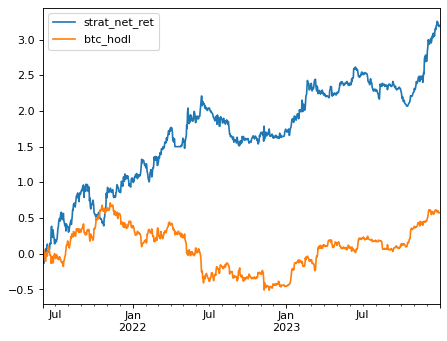

In [23]:
pos = build_positions(
    px_high_train, px_low_train, px_close_train,
        le_lookback=46, se_lookback=35,
    exit_params={"M": 33, "exit_llb": 2, "exit_slb": 40},
    volm=vols_train, vol_lb=50, vol_pct=0.68    # <— trade only if volume > 70th pctile of last 50 bars
)

ret = px_close_train.ffill().pct_change()
pos = pos * np.sqrt(ret.rolling(35, min_periods = 1).std())

port = pos.divide(pos.abs().sum(1), 0).loc[insample_start:]

prices = px_close_train.loc[insample_start:]

net_ret, gross_ret, turnover = backtest_with_costs(prices, port)
print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[insample_start:]),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': gross_ret,
    'strat_net_ret': net_ret,
    'btc_hodl': ret['BTCUSDT'].loc[insample_start:]
})

overall.cumsum().plot();

1. **Returns:**  
   - The strategy significantly outperforms the benchmark, both in **cumulative (761% vs 13.5%)** and **annualized returns (118.2% vs 22.3%)**.  
2. **Risk and Volatility:**  
   - Annualized volatility is higher than HODL (84.1% vs 58.92%), reflecting more active trading.  
   - However, the **Sharpe ratio of 1.41** indicates strong **risk-adjusted performance** relative to the benchmark (0.38).  
3. **Drawdowns:**  
   - Maximum drawdown is substantially lower than HODL (-55% vs -77%), demonstrating the **risk management benefits** of the strategy.  
   - Drawdown duration is also shorter, suggesting quicker recovery from losses.  
4. **Win rate:**
   - Win rate 50.7% above BTC reflects consistent positive signal quality.

The in-sample results demonstrate that the strategy effectively **captures breakout trends**, improves **risk-adjusted returns**, and **reduces drawdowns** compared to simple buy-and-hold, while maintaining manageable trading frequency and holding periods.

In [24]:
consistency_table = pd.DataFrame({
    'strat_ret_2021': calculate_metrics(net_ret.loc['2021']),
    'strat_ret_2022': calculate_metrics(net_ret.loc['2022']),
    'strat_ret_2023': calculate_metrics(net_ret.loc['2023'])
})

btc_table = pd.DataFrame({
    'btc_hodl_2021': calculate_metrics(ret['BTCUSDT'].loc[insample_start:'2021-12-31']),
    'btc_hodl_2022': calculate_metrics(ret['BTCUSDT'].loc['2022']),
    'btc_hodl_2023': calculate_metrics(ret['BTCUSDT'].loc['2023'])
})

print('Strategy Yearly Performance:')
print(consistency_table.to_string(), '\n')

print('----------------------------------------------')
print('BTC Buy and Hold Yearly Performance:')
print(btc_table.to_string())

Strategy Yearly Performance:
                      strat_ret_2021 strat_ret_2022 strat_ret_2023
Cumulative Return            114.34%         37.70%        236.21%
Annualized Return            180.79%         66.88%        147.03%
Annualized Volatility        101.16%         84.03%         72.44%
Sharpe Ratio                1.787148       0.795947       2.029607
Max Drawdown                 -47.76%        -53.59%        -44.55%
Max Drawdown Duration     97.00 days    201.00 days    163.00 days
Win Rate                      52.34%         49.86%         50.41%
Info Ratio                       N/A            N/A            N/A 

----------------------------------------------
BTC Buy and Hold Yearly Performance:
                      btc_hodl_2021 btc_hodl_2022 btc_hodl_2023
Cumulative Return            24.06%       -64.21%       155.61%
Annualized Return            61.86%       -82.09%       103.51%
Annualized Volatility        70.88%        63.74%        44.06%
Sharpe Ratio              

sharpe ratio is consistently above 1 throughout the years

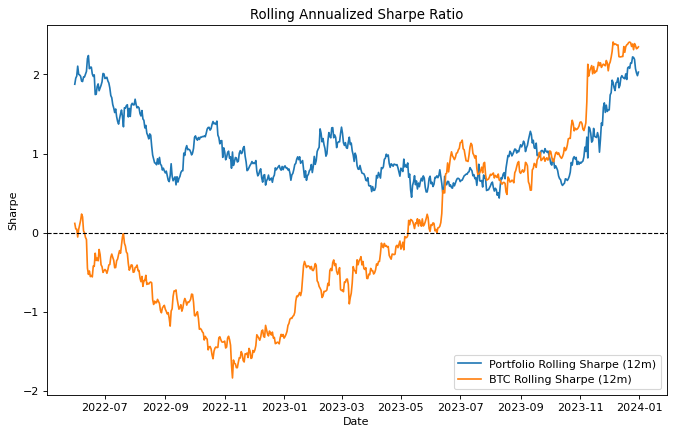

In [25]:
def annualized_sharpe(rets, periods_per_year=365):
    """Compute annualized Sharpe ratio from daily returns."""
    return np.sqrt(periods_per_year) * rets.mean() / rets.std()

# rolling Sharpe (12-month window)
rolling = net_ret.rolling(window=365).apply(
    lambda x: annualized_sharpe(x), raw=False)
rolling_btc = ret.loc[insample_start:]['BTCUSDT'].rolling(window=365).apply(
    lambda x: annualized_sharpe(x), raw=False)


plt.figure(figsize=(10, 6))
plt.plot(rolling.index, rolling, label='Portfolio Rolling Sharpe (12m)')
plt.plot(rolling_btc.index, rolling_btc, label='BTC Rolling Sharpe (12m)')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sharpe')
plt.title('Rolling Annualized Sharpe Ratio')
plt.show()

## Strategy Execution Test Set

The average turnover is 0.24597953334294298
The holding period is 8.130757761913523 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             424.35%       287.34%      156.00%
Annualized Return             129.50%       111.54%       68.47%
Annualized Volatility          77.71%        77.98%       49.41%
Sharpe Ratio                 1.666393      1.430427     1.385727
Max Drawdown                  -39.16%       -43.07%      -28.10%
Max Drawdown Duration     144.00 days   162.00 days  237.00 days
Win Rate                       52.81%        52.39%       51.72%
Info Ratio                   1.952348      1.707933          N/A


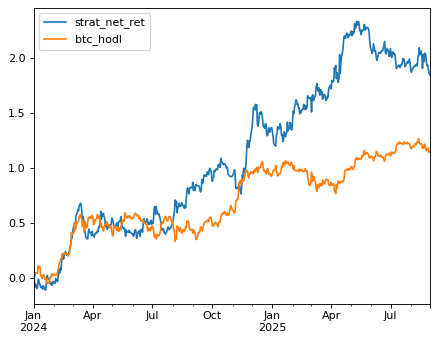

In [26]:
pos = build_positions(
    px_high, px_low, px_close,
    le_lookback=46, se_lookback=35, 
    exit_params={"M": 33, "exit_llb": 2, "exit_slb": 40},
    volm=vols, vol_lb=50, vol_pct=0.68    # <— trade only if volume > 70th pctile of last 50 bars
)

ret = px_close.ffill().pct_change()
pos = pos * np.sqrt(ret.rolling(35, min_periods = 1).std())

port = pos.divide(pos.abs().sum(1), 0).loc[outsample_start:]

prices = px_close.loc[outsample_start:]

net_ret, gross_ret, turnover = backtest_with_costs(prices, port)
print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[outsample_start:]),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': gross_ret,
    'strat_net_ret': net_ret,
    'btc_hodl': ret['BTCUSDT'].loc[outsample_start:]
})

overall.cumsum().plot();

In [27]:
overall.cumsum().iloc[-1]

strat_net_ret    1.861108
btc_hodl         1.142456
Name: 2025-08-31 00:00:00, dtype: float64

In [28]:
# Comparing volatility-scaled returns to the benchmark
target_vol = ret['BTCUSDT'].loc[outsample_start:].std() * np.sqrt(365)
strat_vol = net_ret.std() * np.sqrt(365)
scaled_ret = net_ret * target_vol / strat_vol

scaled_ret_table = pd.DataFrame({
    'strat_net_ret': calculate_metrics(scaled_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[outsample_start:]),
})

print(scaled_ret_table)

                      strat_net_ret     btc_hodl
Cumulative Return           165.28%      156.00%
Annualized Return            70.68%       68.47%
Annualized Volatility        49.41%       49.41%
Sharpe Ratio               1.430427     1.385727
Max Drawdown                -28.76%      -28.10%
Max Drawdown Duration   162.00 days  237.00 days
Win Rate                     52.39%       51.72%
Info Ratio                 1.707933          N/A


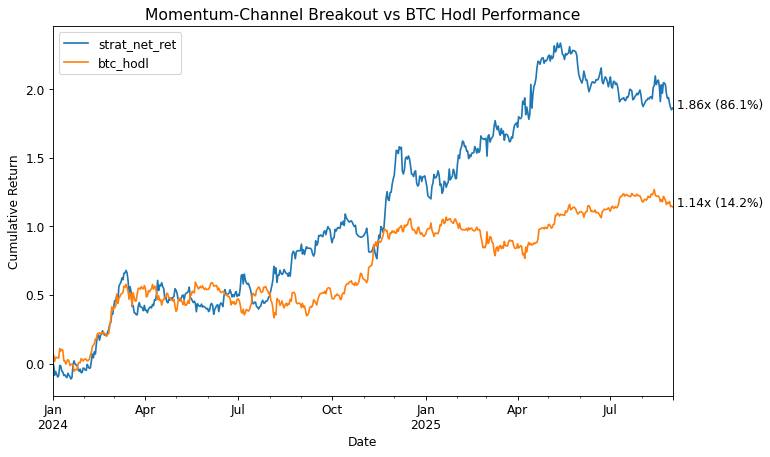

In [29]:
ax = overall.cumsum().plot(title = 'Momentum-Channel Breakout vs BTC Hodl Performance',figsize = (10,6));

ax.set_title("Momentum-Channel Breakout vs BTC Hodl Performance", fontsize=14)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,0], s=' 1.86x (86.1%)', 
        color="black", fontsize=11)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,1], s=' 1.14x (14.2%)', 
        color="black", fontsize=11)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

## Test-Set Performance

The full-set backtest evaluates the strategy over the entire available dataset, providing insights into **out-of-sample and long-term robustness** compared to a simple Bitcoin buy-and-hold (HODL) benchmark.

**Average Turnover:** 0.246 - Approximately 24.6% of the portfolio is traded each period, indicating moderate trading frequency.  
**Average Holding Period:** 8.13 days - Trades are typically held for ~8–9 days, allowing trends to develop while controlling risk exposure.


### Performance
1. **Returns:**  
   - The strategy achieves **substantially higher returns** than HODL, both in cumulative (287.34% net vs 156.00%) and annualized terms (111.54% vs 68.47%).  
2. **Risk and Volatility:**  
   - Annualized volatility is higher than HODL (77.98% vs 49.41%), reflecting active trading.  
   - Despite this, the **Sharpe ratio (1.43 net)** remains strong, indicating good **risk-adjusted performance**.  
   - Drawdown duration is shorter, enabling faster recovery from losses.
3. **Win Rate:**  
   - Win rate 52.39% shows **consistent positive signals**, contributing to strong long-term performance.

The test-set results confirm that the breakout strategy is **robust over the holdout dataset**, generating high returns, **controlled risk**, and shorter drawdowns compared to simple buy-and-hold, while maintaining manageable trading frequency and holding periods.

In [30]:
btc_hodl_ret = ret.loc[outsample_start:]['BTCUSDT']

In [31]:
net_ret.name = 'strat_net_ret'
btc_hodl_ret.name = 'btc_hodl'
df_rets = pd.concat([net_ret, btc_hodl_ret], axis = 1)

strat_net_ret   -0.430708
btc_hodl        -0.280953
dtype: float64


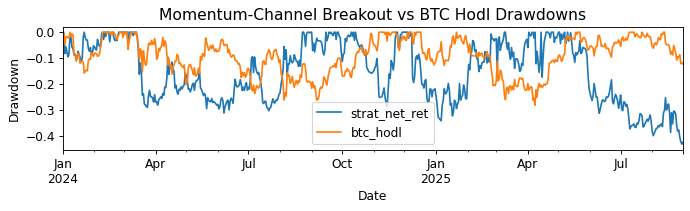

In [32]:
print(drawdown(df_rets).min())
s = drawdown(df_rets)
ax = s.plot( figsize = (10,2), title = "Momentum-Channel Breakout vs BTC Hodl Drawdowns", 
            xlabel = "Date", ylabel = "Drawdown");

ax.set_title("Momentum-Channel Breakout vs BTC Hodl Drawdowns", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Drawdown', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

Strategy maximum drawdown is -43.1%, the strategy maintained shallower drawdowns compared to holding BTC and faster recovery throughout the years

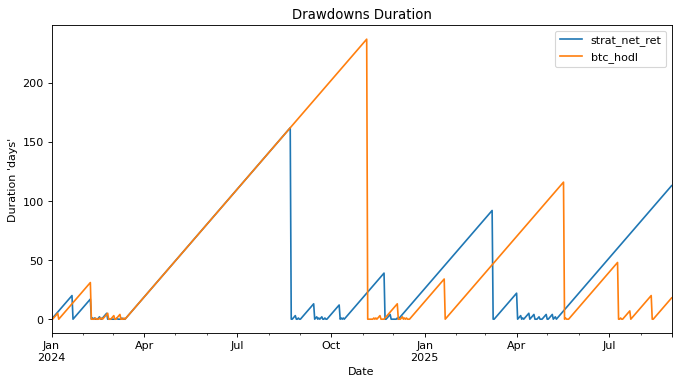

In [33]:
duration(df_rets).plot( figsize = (10,5), title = "Drawdowns Duration", 
                       xlabel = "Date", ylabel = "Duration 'days'");

In [34]:
data = pd.concat([net_ret, btc_hodl_ret], axis=1).dropna()
y = data.iloc[:,0]   # strategy
x = data.iloc[:,1]   # benchmark

# Regression (to get alpha & beta)
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
alpha, beta = model.params
alpha_ann = alpha * 365  # annualized alpha

# Residual Returns
resid_ret = y - beta * x

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          strat_net_ret   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     20.35
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           7.75e-06
Time:                        10:05:21   Log-Likelihood:                 1094.4
No. Observations:                 609   AIC:                            -2185.
Df Residuals:                     607   BIC:                            -2176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.199      0.0

In [35]:
print("Alpha (annualized):", alpha_ann)
print("Beta:", beta)

Alpha (annualized): 1.3100614664885006
Beta: -0.2842300247129529


- **Alpha (131.0% annualized)**: The strategy consistently generates excess returns independent of market movements.  
- **Beta (-0.28)**: The negative beta indicates that the strategy tends to move **opposite to the market**, offering a potential hedge and diversification benefit.  

In [36]:
SR = net_ret.mean() / net_ret.std() * np.sqrt(365)
IR = resid_ret.mean() / resid_ret.std() * np.sqrt(365)

print('Strategy Sharpe Ratio is ', SR)
print('Strategy Information Ratio is ', IR)

Strategy Sharpe Ratio is  1.430427253047047
Strategy Information Ratio is  1.7079329513836825


Strategy information ratio is 1.71 which shows consistent and risk efficiency over the benchmark.

At **1.71 IR**, this strategy provides a reliable edge over BTC buy-and-hold

In [37]:
vol = {}
vol['original volatility'] = net_ret.std()*np.sqrt(365)
vol['residual volatility'] = resid_ret.std()*np.sqrt(365)
vol

{'original volatility': 0.7797967498462015,
 'residual volatility': 0.7670450209577333}

In [38]:
print('Strategy return correlation with btc hodl return is ', net_ret.corr(btc_hodl_ret))
print('Strategy residual return correlation with btc hodl return is ', resid_ret.corr(btc_hodl_ret))

Strategy return correlation with btc hodl return is  -0.1801051204885943
Strategy residual return correlation with btc hodl return is  -3.9291372100510107e-16
